In [1]:
import numpy as np
import pandas as pd
import re
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import Binarizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
rela1 = Path("../data/ODI-2020.csv")
abso1 = rela1.absolute()
ODI_raw = pd.read_csv(abso1, sep=';')
ODI_pro = pd.read_csv("../data/ODI_pro.csv")

In [3]:
ODI = ODI_raw.filter(['What is your gender?',
                    'Have you taken a course on machine learning?',
                    'Have you taken a course on information retrieval?', 
                    'Have you taken a course on statistics?', 
                    'Have you taken a course on databases?',
                    'You can get 100 euros if you win a local DM competition, or we don’t hold any competitions \
                    and I give everyone some money (not the same amount!). How much do you think \
                    you would deserve then?',
                    'Number of neighbors sitting around you?',
                    'What is your stress level (0-100)?']).copy()
ODI['DM'] = ODI_raw.iloc[:,11].copy()
ODI = ODI.rename(columns = 
                 {'What is your gender?':'gender',
                 'Have you taken a course on machine learning?':'machine learning',
                 'Have you taken a course on information retrieval?':'information retrieval',
                 'Have you taken a course on statistics?':'statistics',
                 'Have you taken a course on databases?':'databases', 
                'Number of neighbors sitting around you?':'neighbors',
                 'What is your stress level (0-100)?':'stress level'})

In [4]:
ODI = ODI[['gender','machine learning','information retrieval','statistics','databases','neighbors',
          'DM','stress level']]

In [5]:
ODI = pd.merge(ODI_pro, ODI, left_index = True, right_index = True, how='outer')

In [6]:
ODI['gender'] = ODI['gender'].str.replace('female', 'F')
ODI['gender'] = ODI['gender'].str.replace('male', 'M')
F = ODI['gender'].str.contains('F')
N = ODI['gender'].str.contains('unknown')
M = ODI['gender'].str.contains('M')
ODI['gender'] = np.where(F, int('1'),
                        np.where(N, float('NaN'),
                            np.where(M, int('0'),
                                    ODI['gender'].str.replace('-', ' '))))
T = ODI['machine learning'].str.contains('yes')
N = ODI['machine learning'].str.contains('unknown')
F = ODI['machine learning'].str.contains('no')
ODI['machine learning'] = np.where(T, int('1'),
                        np.where(N, float('NaN'),
                            np.where(F, int('0'),
                                    ODI['machine learning'].str.replace('-', ' '))))

T = ODI['information retrieval'].str.contains('1')
N = ODI['information retrieval'].str.contains('unknown')
F = ODI['information retrieval'].str.contains('0')
ODI['information retrieval'] = np.where(T, int('1'),
                        np.where(N, float('NaN'),
                            np.where(F, int('0'),
                                    ODI['information retrieval'].str.replace('-', ' '))))

T = ODI['statistics'].str.contains('mu')
N = ODI['statistics'].str.contains('unknown')
F = ODI['statistics'].str.contains('sigma')
ODI['statistics'] = np.where(T, int('1'),
                        np.where(N, float('NaN'),
                            np.where(F, int('0'),
                                    ODI['statistics'].str.replace('-', ' '))))

T = ODI['databases'].str.contains('ja')
N = ODI['databases'].str.contains('unknown')
F = ODI['databases'].str.contains('nee')
ODI['databases'] = np.where(T, int('1'),
                        np.where(N, float('NaN'),
                            np.where(F, int('0'),
                                    ODI['databases'].str.replace('-', ' '))))

In [7]:
def ExtractNumber(item):
    if isinstance(item, float):
        num = item
    elif isinstance(item, int):
        num = float(item)
    elif isinstance(item, str):
        nstr = re.findall(r'\d+\.?\d*', item)
        nlist = list(map(float,nstr))
        if len(nlist) == 0:
            num = float('NaN')
        else:
            num = nlist[0]
    else:
        num = float('NaN')
    return num

ODI['neighbors'] = ODI['neighbors'].map(ExtractNumber)
ODI['DM'] = ODI['DM'].map(ExtractNumber)
ODI['stress level'] = ODI['stress level'].map(ExtractNumber)

In [8]:
ODI = ODI.drop_duplicates()

In [9]:
# outliers
def InvalidValue(minv, maxv, item):
    if item < minv or item > maxv:
        item = float('NaN')
    return item

ODI['gender'] = ODI['gender'].map(lambda x: InvalidValue(0, 1, x))
ODI['machine learning'] = ODI['machine learning'].map(lambda x: InvalidValue(0, 1, x))
ODI['information retrieval'] = ODI['information retrieval'].map(lambda x: InvalidValue(0, 1, x))
ODI['statistics'] = ODI['statistics'].map(lambda x: InvalidValue(0, 1, x))
ODI['databases'] = ODI['databases'].map(lambda x: InvalidValue(0, 1, x))
ODI['neighbors'] = ODI['neighbors'].map(lambda x: InvalidValue(0, 500, x))
ODI['DM'] = ODI['DM'].map(lambda x: InvalidValue(0, 100, x))
ODI['stress level'] = ODI['stress level'].map(lambda x: InvalidValue(0, 100, x))

In [10]:
ODI.describe()

,Artificial Intelligence,Business,Computational Science,Computer Science,Engineer,Finance,Information Science,Others,Physics,QRM,gender,machine learning,information retrieval,statistics,databases,neighbors,DM,stress level
count,278.000000,278.000000,278.000000,278.000000,278.000000,278.00000,278.000000,278.000000,278.000000,278.000000,274.000000,275.000000,265.000000,266.000000,272.000000,275.000000,259.000000,277.000000
mean,0.258993,0.089928,0.104317,0.363309,0.021583,0.05036,0.021583,0.057554,0.007194,0.025180,0.430657,0.640000,0.298113,0.898496,0.529412,1.483636,29.377259,42.072202
std,0.438872,0.286595,0.306222,0.481820,0.145579,0.21908,0.145579,0.233318,0.084666,0.156954,0.496074,0.480875,0.458295,0.302564,0.500054,8.614340,36.320768,27.731539
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,20.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,10.000000,40.000000
75%,1.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,50.000000,65.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000,100.000000,100.000000


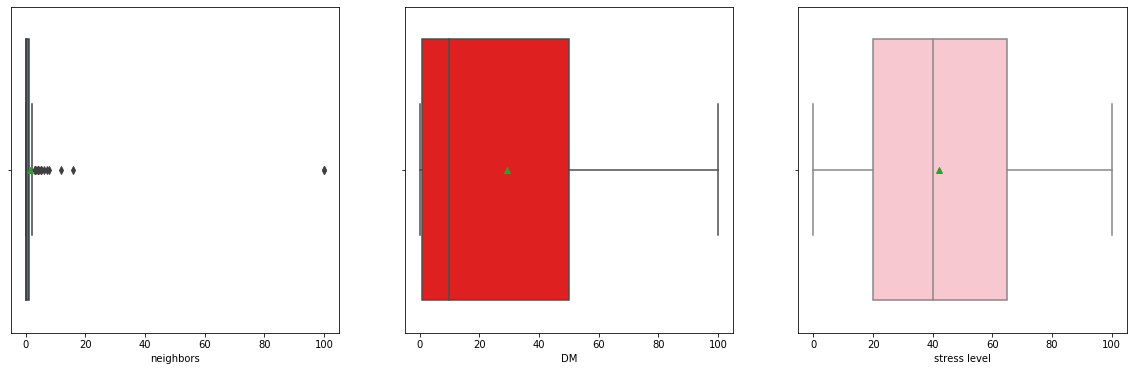

In [11]:
fig= plt.figure(figsize=(20,6))
plt.subplot(131)
ax = sns.boxplot(x = ODI['neighbors'], showmeans=True)
plt.subplot(132)
ax = sns.boxplot(x = ODI['DM'], showmeans=True, color='r')
plt.subplot(133)
ax = sns.boxplot(x = ODI['stress level'], showmeans=True, color='pink')

In [12]:
def RemoveOutliers(lower_bound, upper_bound, item):
    if item > lower_bound or item < upper_bound:
        item = float('NaN')
    return item

Q1 = ODI['neighbors'].quantile(0.25)
Q3 = ODI['neighbors'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1*1.5
upper_bound = Q3*1.5

ODI['neighbors'] = ODI['neighbors'].map(lambda x: InvalidValue(lower_bound, upper_bound, x))
ODI['neighbors'].describe()

count    229.000000
mean       0.222707
std        0.416975
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: neighbors, dtype: float64

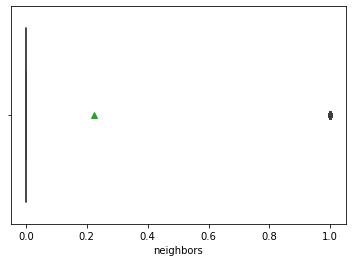

In [13]:
sns.boxplot(x = ODI['neighbors'], showmeans=True)

In [14]:
print(ODI.isnull().sum())

Artificial Intelligence     0
Business                    0
Computational Science       0
Computer Science            0
Engineer                    0
Finance                     0
Information Science         0
Others                      0
Physics                     0
QRM                         0
gender                      4
machine learning            3
information retrieval      13
statistics                 12
databases                   6
neighbors                  49
DM                         19
stress level                1
dtype: int64


In [15]:
ODI = ODI.drop(['neighbors'], axis=1)

Text(0.5, 0, 'stress level')

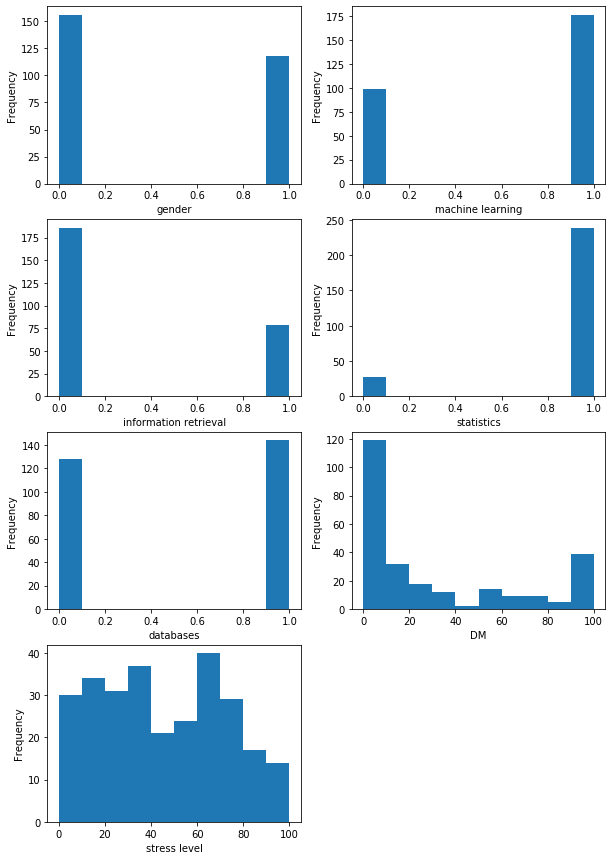

In [16]:
# missing value
fig= plt.figure(figsize=(10,15))
plt.subplot(421)
ODI['gender'].plot.hist(bins=10)
plt.xlabel('gender')
plt.subplot(422)
ODI['machine learning'].plot.hist(bins=10)
plt.xlabel('machine learning')
plt.subplot(423)
ODI['information retrieval'].plot.hist(bins=10)
plt.xlabel('information retrieval')
plt.subplot(424)
ODI['statistics'].plot.hist(bins=10)
plt.xlabel('statistics')
plt.subplot(425)
ODI['databases'].plot.hist(bins=10)
plt.xlabel('databases')
plt.subplot(426)
ODI['DM'].plot.hist(bins=10)
plt.xlabel('DM')
plt.subplot(427)
ODI['stress level'].plot.hist(bins=10)
plt.xlabel('stress level')

In [17]:
ODI['gender'] = ODI['gender'].fillna(0) 
ODI['machine learning'] = ODI['machine learning'].fillna(1)  
ODI['information retrieval'] = ODI['information retrieval'].fillna(0) 
ODI['statistics'] = ODI['statistics'].fillna(1) 
ODI['databases'] = ODI['databases'].fillna(1) 
ODI['DM'] = ODI['DM'].fillna(ODI['DM'].median()) 
ODI['stress level'] = ODI['stress level'].fillna(ODI['stress level'].median()) 

In [18]:
ODI['DM'] = ODI['DM']/100.0
ODI['stress level'] = ODI['stress level']/100.0

In [19]:
ODI.head()

,Artificial Intelligence,Business,Computational Science,Computer Science,Engineer,Finance,Information Science,Others,Physics,QRM,gender,machine learning,information retrieval,statistics,databases,DM,stress level
0,0,0,1,0,0,0,0,0,0,0,1.0,0.0,0.0,1.0,1.0,0.04,0.00
1,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,1.0,0.0,0.25,0.85
2,0,0,1,0,0,0,0,0,0,0,1.0,0.0,0.0,1.0,1.0,0.10,0.50
3,0,0,0,0,0,1,0,0,0,0,1.0,0.0,0.0,1.0,0.0,0.99,0.10
4,0,1,0,0,0,0,0,0,0,0,0.0,1.0,0.0,1.0,1.0,0.80,0.60


In [20]:
ODI.describe()

,Artificial Intelligence,Business,Computational Science,Computer Science,Engineer,Finance,Information Science,Others,Physics,QRM,gender,machine learning,information retrieval,statistics,databases,DM,stress level
count,278.000000,278.000000,278.000000,278.000000,278.000000,278.00000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000
mean,0.258993,0.089928,0.104317,0.363309,0.021583,0.05036,0.021583,0.057554,0.007194,0.025180,0.424460,0.643885,0.284173,0.902878,0.539568,0.280529,0.420647
std,0.438872,0.286595,0.306222,0.481820,0.145579,0.21908,0.145579,0.233318,0.084666,0.156954,0.495152,0.479713,0.451833,0.296658,0.499331,0.353936,0.276817
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.010000,0.200000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.100000,0.400000
75%,1.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.650000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
#ODI.to_csv('/Users/xuluyao/Desktop/Data Mining/DM_assignment1/Q1/ODI_final.csv', index=False)

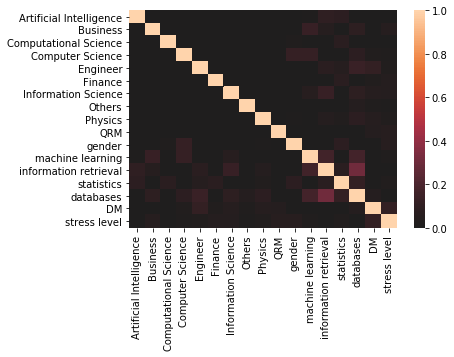

In [22]:
# Correlation
sns.heatmap(ODI.corr(),vmin=0, vmax=1, center=0)
plt.show()

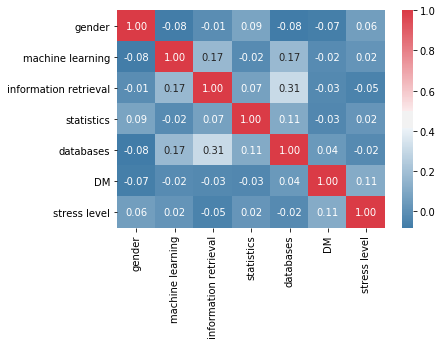

In [23]:
ODI.iloc[:,-7:].corr()
colormap = sns.diverging_palette(240, 10, sep=20, as_cmap=True)
# plt.figure(figsize = (8,8))
sns.heatmap(ODI.iloc[:,-7:].corr(), cmap=colormap,annot=True, fmt=".2f")
plt.show()

Text(0.5, 0, 'number of students')

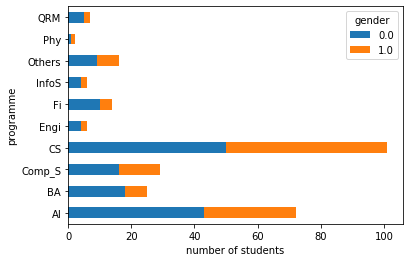

In [24]:
# Plotting1: programmes and gender
gender_pro = ODI[['Artificial Intelligence', 'Business', 'Computational Science', 'Computer Science', 'Engineer', 'Finance', 'Information Science', 'Others', 'Physics', 'QRM']].groupby(ODI['gender']).sum()
gender_pro = gender_pro.rename(columns = 
                 {'Risk Management':'RM','Computer Science':'CS','Artificial Intelligence':'AI','Business':'BA',
                  'Computational Science':'Comp_S','Engineer':'Engi','Finance':'Fi','Others':'Others',
                  'QRM':'QRM','Physics':'Phy','Information Science':'InfoS',
                  })
pro_gender = gender_pro.transpose()
pro_gender.plot.barh(stacked=True)
plt.ylabel('programme')
plt.xlabel('number of students')

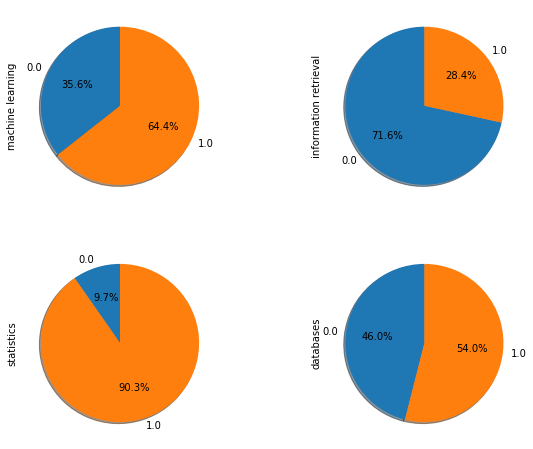

In [25]:
# Plotting2: courses
course_df = ODI.iloc[:,-6:-2].copy()
course_ratio_df = course_df.apply(lambda x: x.value_counts())
course_ratio = pd.DataFrame(course_ratio_df)
fig= plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
course_ratio['machine learning'].plot.pie(autopct='%1.1f%%',shadow=True,startangle=90)
plt.subplot(2,2,2)
course_ratio['information retrieval'].plot.pie(autopct='%1.1f%%',shadow=True,startangle=90)
plt.subplot(2,2,3)
course_ratio['statistics'].plot.pie(autopct='%1.1f%%',shadow=True,startangle=90)
plt.subplot(2,2,4)
course_ratio['databases'].plot.pie(autopct='%1.1f%%',shadow=True,startangle=90)

In [26]:
# Plotting3: self evaluation
self_evaluation = ODI[['DM','stress level']].groupby(ODI['gender']).mean()
self_evaluation

,DM,stress level
gender,,
0.0,0.300938,0.406625
1.0,0.252857,0.439661


In [27]:
def ClassStress(item):
    if item >= 0.5:
        item = 1
    else:
        item = 0
    return item
ODI['stress level'] = ODI['stress level'].apply(lambda x: ClassStress(x))

In [28]:
# Logistic Regression
import sklearn
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

LR = linear_model.LogisticRegression() 
features = ['Artificial Intelligence', 'Business', 'Computational Science', 'Computer Science', 'Engineer', 'Finance', 'Information Science', 'Others', 'Physics', 'QRM',
            'information retrieval','statistics','databases','DM']
X = ODI[features]
Y = ODI['stress level']
LR.fit(X,Y)
scores_LR = cross_val_score(LR, X, Y, cv = 5, scoring='accuracy')
print(np.mean(scores_LR)) #求平均的交叉检验的值

0.5644179894179895


In [29]:
# KNN
from sklearn import neighbors
KNN = neighbors.KNeighborsClassifier()
KNN.fit(X, Y)
scores_KNN = cross_val_score(KNN, X, Y, cv = 5, scoring='accuracy')
print(np.mean(scores_KNN))

0.5071428571428571


In [30]:
# Gradient Boosting Classifier
gbc = GradientBoostingClassifier()
gbc.fit(X, Y)
scores_gbc = cross_val_score(gbc, X, Y, cv = 5, scoring='accuracy')
print(np.mean(scores_gbc))

0.554100529100529


In [31]:
# Random forests
rfm = RandomForestClassifier(n_estimators=100)
rfm.fit(X, Y)
scores_rfm = cross_val_score(rfm, X, Y, cv = 5, scoring='accuracy')
print(np.mean(scores_rfm))

0.5252645502645503


In [32]:
# SVM
svc = SVC()
svc.fit(X, Y)
scores_svc = cross_val_score(svc, X, Y, cv = 5, scoring='accuracy')
print(np.mean(scores_svc))

0.5466931216931217


In [33]:
# Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X, Y)
scores_gnb = cross_val_score(gnb, X, Y, cv = 5, scoring='accuracy')
print(np.mean(scores_gnb))

0.5574074074074075


In [34]:
# 
dt = DecisionTreeClassifier()
dt.fit(X, Y)
scores_dt = cross_val_score(dt, X, Y, cv = 5, scoring='accuracy')
print(np.mean(scores_dt))

0.513888888888889
